In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.linalg
import random

In [2]:
S0 = 172
X = 35000
T = 100
N = 100
deltaT = T/N
c = 2.5e-7
sigma = np.array([3.51e-3, 3.3e-2,1.172e-1])
eta = np.array([1e-6,5e-6,25e-6])
matrix_sigma = np.array([[0.9349, 0.0434, 0.0217],[0.7164, 0.2239, 0.0597],[0.4400, 0.4800, 0.0800]])
matrix_eta = np.array([[0.50, 0.30, 0.20],[0.15, 0.80, 0.05],[0.05, 0.05, 0.90]])

In [3]:
def sigma_path(matrix_sigma,n):
  sigma_p = np.zeros(n)
  StartingState = 0 #low
  CurrentState = StartingState
  sigma_p[0] = CurrentState
  i=1
  while i<n:
    CurrentState = np.random.choice([0, 1, 2], p=matrix_sigma[CurrentState])
    sigma_p[i] = CurrentState
    i += 1
  return sigma_p

def eta_path(matrix_eta,n):
  eta_p = np.zeros(n)
  StartingState = 0 #low
  CurrentState = StartingState
  eta_p[0] = CurrentState
  i=1
  while i<n:
    CurrentState = np.random.choice([0, 1, 2], p=matrix_eta[CurrentState])
    eta_p[i] = CurrentState
    i += 1
  return eta_p

def xi_path(n):
  return np.random.normal(0,1,n)

In [4]:
def cost_function(x_p, sigma_p, eta_p, xi_p):
  eta_tilda = eta_p - c/2
  x_p0 = np.append(x_p,0)
  sum_term = np.diff(-(x_p0))**2*eta_tilda - x_p*sigma_p*xi_p
  Cx = c*X**2/2 + np.sum(sum_term)
  return Cx

# Constant Speed Strategy and Optimal Risk Neutral Strategy

In [5]:
def simulation(xn, size):
  C_size = np.zeros(size)
  for i in tqdm(range(size)):
    C_size[i] = cost_function(xn, sigma[sigma_path(matrix_sigma,N).astype(int)], eta[eta_path(matrix_eta,N).astype(int)], xi_path(N))
  return C_size

In [6]:
def risk_neutral_const_eta():
  n = np.arange(0,N)
  xn_star = X*(N-n)/N
  return xn_star

In [7]:
def plot_shares(xn, ls):
  n = np.arange(0,N+1)
  plt.plot(n, xn/X, linestyle=ls)

In [8]:
def plot_histogram(x):
  plt.hist(x, bins=40,rwidth=0.75, label = 'Std C(x) = {std:.0f}$'.format(std = np.std(x,ddof=1)))
  plt.axvline(np.mean(x),color = 'red',linestyle='dashed',label = 'Mean C(x) = {mean:.0f}$'.format(mean = np.mean(x)))
  plt.legend()

In [9]:
def E_v_eta(v):
  p = matrix_eta[v]
  return np.dot(p, eta)-c/2

def a_seq_backward():
  a_seq = np.zeros((N,3))#a_n^(v)
  v = np.arange(0,3)
  E_v_Nm1 =  E_v_eta(v)

  a_seq[N-1] = eta-c/2
  n = N-2
  while n > -1:
    for v in range(3):
      sum_term = 0
      for w in range(3):
        a_w = a_seq[n+1]
        sum_term += matrix_eta[w,v]*a_w[w]
        a_seq[n,v] = (E_v_Nm1[v]*sum_term)/(E_v_Nm1[v]+sum_term)
    n -= 1
  return a_seq

In [10]:
def risk_neutral_non_const(a_seq,v):
  E_v_Nm1 = E_v_eta(v)
  xn_star = np.zeros(N)
  xn_star[0] = X
  for n in range(1,N):
    a_w = a_seq[n]
    sum_term = 0
    for w in range(3):
      sum_term += matrix_eta[w,v[n]]*a_w[w]
    xn_star[n] = xn_star[n-1]*(E_v_Nm1[n]/(E_v_Nm1[n]+sum_term))
  return xn_star

In [11]:
constant_speed_xn=risk_neutral_const_eta()

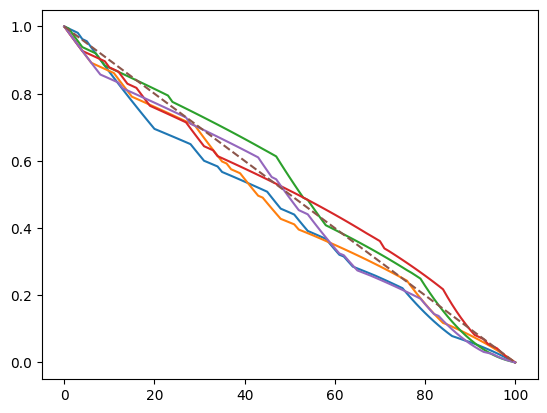

In [12]:
for i in range(5):
  v = eta_path(matrix_eta,N).astype(int)
  a_seq = a_seq_backward()
  x_star = risk_neutral_non_const(a_seq,v)
  plot_shares(np.append(x_star,0),"solid")
plot_shares(np.append(constant_speed_xn,0),"dashed")

In [13]:
def simulation_12(size):
  C1_size = np.zeros(size)
  C2_size = np.zeros(size)
  x_ns = []
  n = np.arange(0,N)
  xn = X*(N-n)/N
  for i in tqdm(range(size)):
    s_i = sigma_path(matrix_sigma,N).astype(int)
    e_i = eta_path(matrix_eta,N).astype(int)
    xi = xi_path(N)
    a_seq = a_seq_backward()
    x_star = risk_neutral_non_const(a_seq,e_i)
    x_ns.append(x_star)
    C1_size[i] = cost_function(xn, sigma[s_i], eta[e_i], xi)
    C2_size[i] = cost_function(x_star, sigma[s_i], eta[e_i], xi)
  return C1_size, C2_size, x_ns

In [14]:
sim12 = simulation_12(size=50000)

  0%|          | 35/50000 [00:00<04:46, 174.23it/s]

100%|██████████| 50000/50000 [04:40<00:00, 178.46it/s]


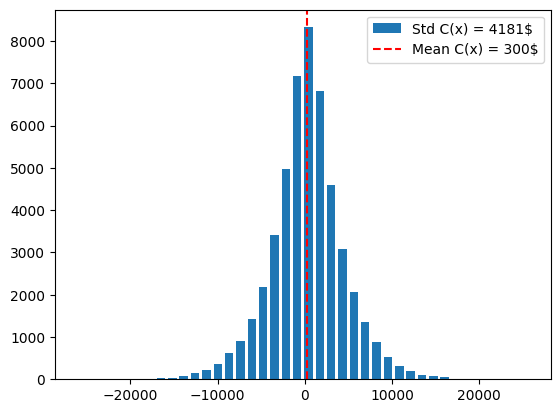

In [15]:
plot_histogram(sim12[0])

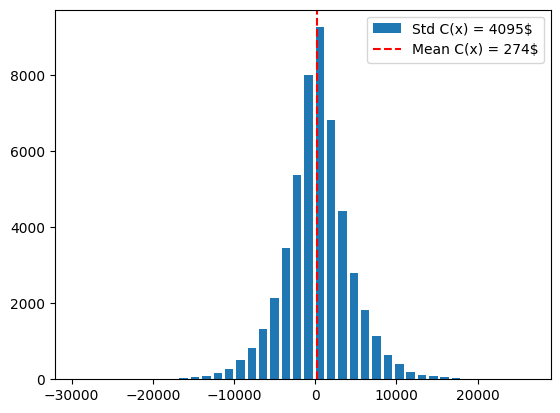

In [16]:
plot_histogram(sim12[1])

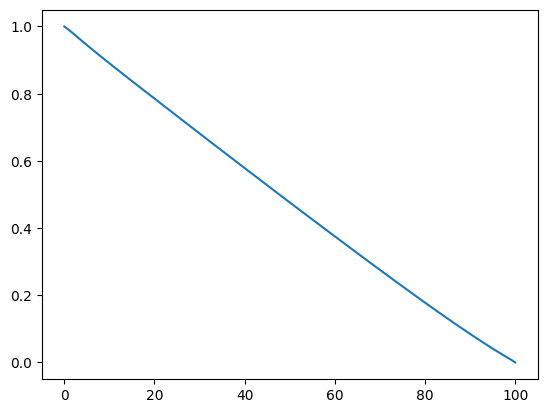

In [17]:
xns = np.array(sim12[2])
plot_shares(np.append(np.mean(xns,axis=0),0),"solid")

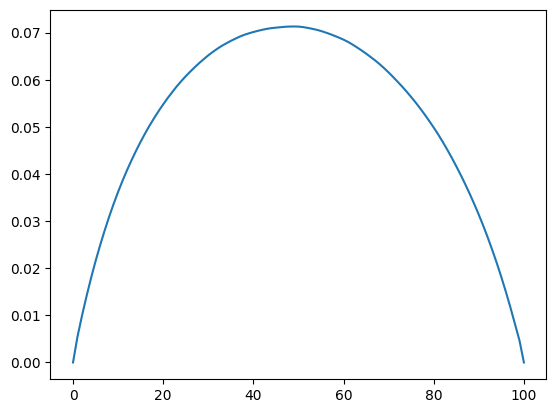

In [18]:
plot_shares(np.append(np.std(xns,axis=0,ddof=1),0),"solid")

# Expected Exponential Cost

### Almgren-Chriss strategy -- constant $\sigma,\eta$

In [19]:
alpha_list = [2e-6, 1e-5, 2e-5]

In [20]:
def x_star_exp(kappa):
  n = np.arange(0,N)
  return np.sinh(kappa*(T-n*deltaT))/np.sinh(kappa*T)*X

In [21]:
def kappa_n(sigma_m, eta_m, alpha):
  x = alpha*sigma_m**2*deltaT
  y = 4*eta_m-2*c
  z = x/y+1
  return np.arccosh(z)/deltaT

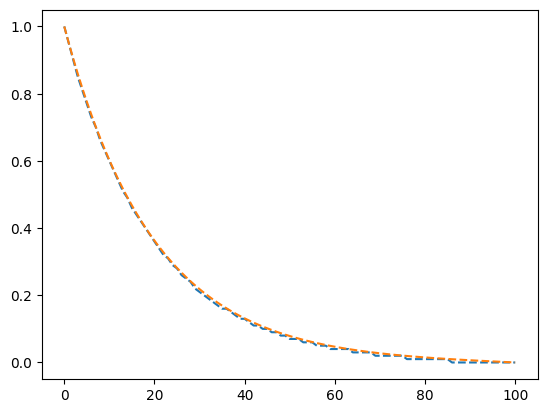

In [23]:
alpha = alpha_list[2]
kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
x_n_AC = x_star_exp(kappa_p)
x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
plot_shares(np.append(x_1,0),"dashed")
plot_shares(np.append(x_n_AC,0),"dashed")

In [24]:
alpha = 1e-8
#the article use alpha = 2e-5 but I didn't replicate the same result
#the following plot is closer to the plot in the paper from alpha = 1e-8

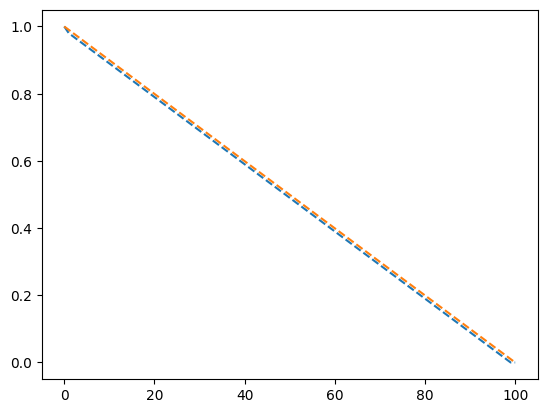

In [25]:
kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
x_n_AC = x_star_exp(kappa_p)
x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
plot_shares(np.append(x_1,0),"dashed")
plot_shares(np.append(x_n_AC,0),"dashed")

In [26]:
def simulation_3(x_n_AC, size):
  C2_size = np.zeros(size)

  n = np.arange(0,N)
  xn = X*(N-n)/N
  for i in tqdm(range(size)):
    s_i = sigma_path(matrix_sigma,N).astype(int)
    e_i = eta_path(matrix_eta,N).astype(int)
    xi = xi_path(N)
    C2_size[i] = cost_function(x_n_AC, sigma[s_i], eta[e_i], xi)
  return C2_size

Try constant $\sigma, \eta$, no v/w anymore. Theorem 4.1 becomes:
for all n-1 we need to find all $0 \le x_{n-1} \le X$, for each $x_{n-1}$, find $x_n^*$ from calculating all $x_n$ for all $0 \le x_{n} \le x_{n-1}$ and corresponding J then we have all J_n-1 for all x_n-1

Once we have all J_n we could solve x_n* from x0 to x1* to...x_N-1

In [27]:
def min_finder(J):
  return np.argmin(J)

In [28]:
eta_mean = np.mean(eta)
sigma_mean = np.mean(sigma)
def constant_vol_liq(x_n, x_n_1):
  return np.exp(alpha*(x_n-x_n_1)**2*(eta_mean-c/2)+1/2*(x_n*alpha*sigma_mean)**2*deltaT)

In [29]:
def J_value_function(J_n,grid_length):
  #Given Jn find Jn-1 by computing all xn-1 and optimize xn
  J_n_1 = np.ones(X//grid_length+1)
  x_possible = np.arange(0,X+grid_length,grid_length)
  for x_n_1 in x_possible:
    if x_n_1 == 0:
      x_n = 0
      x_n_index = 0
      continue
    else:
      x_n = np.arange(0,x_n_1+grid_length,grid_length)
      x_n_index = np.arange(0,x_n_1//grid_length+1).astype(int)
    J_value = constant_vol_liq(x_n, x_n_1)*J_n[x_n_index]
    min_index = min_finder(J_value)
    J_n_1[x_n_index[-1]] = J_value[min_index]
  return J_n_1

In [30]:
def J_value(alpha,grid_length):
    # compute the J matrix for all n from 1 to 100
    J = list(range(100))
    x_Np1 = np.arange(0,X+grid_length,grid_length)
    J_Np1 = np.exp(alpha*x_Np1**2*(eta_mean-c/2))
    J[0] = J_value_function(J_Np1,grid_length)
    for i in tqdm(range(1,100)):
        J[i] = J_value_function(J[i-1],grid_length)
    J = np.array(J)
    return J

In [31]:
def backward_optimize_x(J,grid_length):
    #backward from x1 to xN-1
    x_arr = np.zeros(100)
    x_possible = np.arange(0,X+grid_length,grid_length)
    x_arr[0] = x_possible[np.argmin(constant_vol_liq(x_possible,X)*J[99])]
    for i in range(1,100):
        x_i_available = np.arange(0,x_arr[i-1]+grid_length,grid_length).astype(int)
        x_i_available_index = np.arange(0,x_arr[i-1]/grid_length+1).astype(int)
        x_arr[i] = x_i_available[np.argmin(constant_vol_liq(x_i_available,x_arr[i-1])*J[99-i,x_i_available_index])]
    return x_arr

In [32]:
alpha = 1e-5
J = J_value(alpha,35)
x_arr = backward_optimize_x(J,35)

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:03<00:00, 29.70it/s]


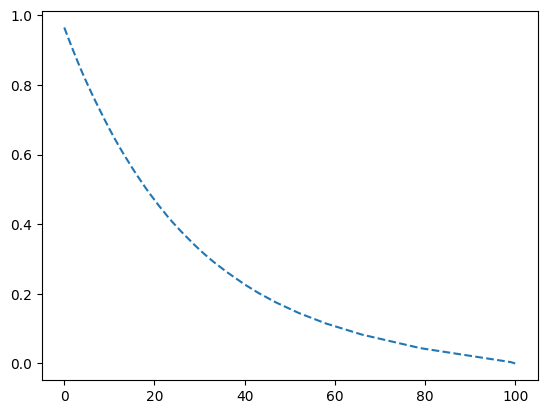

In [33]:
plot_shares(np.append(x_arr,0),"dashed")
# the result are same as from Almgren-Chriss when constant sigma/eta

Build $J_v^{N-1}(x_{N-1})$

In [34]:
def stochastic_vol_liq(v1,v2,x_n,x_n_1,alpha,x_n_index,J_n):
  sum_term = 0
  for w1 in range(3):
    for w2 in range(3):
      sum_term += matrix_eta[w2,v2]*matrix_sigma[w1,v1]*np.exp(alpha*(x_n_1-x_n)**2*(eta[w2]-c/2)+1/2*(x_n*alpha*sigma[w1])**2*deltaT)*J_n[x_n_index,w1,w2]
  return sum_term

In [35]:
def stochastic_J_value_function(J_n,grid_length,alpha):
  #Given Jn find Jn-1 by computing all xn-1 and optimize xn, under stochastic vol/liq
  grid_size = X//grid_length+1
  J_n_1 = np.zeros((grid_size,3,3))
  x_possible = np.arange(0,X+grid_length,grid_length)
  for x_n_1 in x_possible:
    if x_n_1 == 0:
      x_n = 0
      x_n_index = 0
      #continue
    else:
      x_n = np.arange(0,x_n_1+grid_length,grid_length)
      x_n_index = np.arange(0,x_n_1//grid_length+1).astype(int)
    J_value = np.zeros((x_n_1//grid_length+1,3,3))
    
    for v1 in range(3):
      for v2 in range(3):
        J_value[:,v1,v2] = stochastic_vol_liq(v1,v2,x_n,x_n_1,alpha,x_n_index,J_n)
        min_index = min_finder(J_value[:,v1,v2])
        if np.size(x_n_index)>1:
          J_n_1[x_n_index[-1],v1,v2] = J_value[min_index,v1,v2]
        else:
          J_n_1[x_n_index,v1,v2] = J_value[min_index,v1,v2]
  return J_n_1

In [36]:
def stochastic_J_value(alpha,grid_length):
    # compute the J matrix for all n from 1 to 100
    J = list(range(100))
    x_Np1 = np.arange(0,X+grid_length,grid_length)
    grid_size = X//grid_length+1
    J_Np1 = np.zeros((grid_size,3,3))

    for v1 in range(3):
        for v2 in range(3):
            sum_term = 0
            for w1 in range(3):
                for w2 in range(3):
                    sum_term += matrix_eta[w2,v2]*matrix_sigma[w1,v1]*np.exp(alpha*x_Np1**2*(eta[w2]-c/2))
            J_Np1[:,v1,v2] = sum_term
    J[0] = stochastic_J_value_function(J_Np1,grid_length,alpha)
    for i in tqdm(range(1,100)):
        J[i] = stochastic_J_value_function(J[i-1],grid_length,alpha)
    J = np.array(J)
    return J

In [37]:
def stochastic_backward_optimize(v1_path,v2_path,J,grid_length,alpha):
    #backward from x1 to xN-1
    x_arr = np.zeros(100)
    x_possible = np.arange(0,X+grid_length,grid_length)
    x_possible_index = np.arange(0,X//grid_length+1)
    v1,v2 = v1_path[0],v2_path[0]
    x_arr[0] = x_possible[np.argmin(stochastic_vol_liq(v1,v2,x_possible,X,alpha,x_possible_index,J[99]))]
    for i in range(1,100):
        x_i_available = np.arange(0,x_arr[i-1]+grid_length,grid_length).astype(int)
        x_i_available_index = np.arange(0,x_arr[i-1]/grid_length+1).astype(int)
        v1,v2 = v1_path[i],v2_path[i]
        x_arr[i] = x_i_available[np.argmin(stochastic_vol_liq(v1,v2,x_i_available,x_arr[i-1],alpha,x_i_available_index,J[99-i]))]
    return x_arr

In [38]:
def simulation_stochastic_exp_cost(alpha, grid_length, size):
  C1_size = np.zeros(size)
  C2_size = np.zeros(size)
  kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
  x_n_AC = x_star_exp(kappa_p)
  x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
  x_ns = []

  J = stochastic_J_value(alpha,grid_length)
  for i in tqdm(range(size)):
    s_i = sigma_path(matrix_sigma,N).astype(int)
    e_i = eta_path(matrix_eta,N).astype(int)
    xi = xi_path(N)
    x_star = stochastic_backward_optimize(s_i,e_i,J,grid_length,alpha)
    x_ns.append(x_star)
    C1_size[i] = cost_function(x_star, sigma[s_i], eta[e_i], xi)
    C2_size[i] = cost_function(x_1, sigma[s_i], eta[e_i], xi)
  return C1_size, C2_size, x_ns

In [39]:
grid_length = 350
simexp_lst = []
for alpha in alpha_list:
    simexp_lst.append(simulation_stochastic_exp_cost(alpha, grid_length, size=50000))

100%|██████████| 50000/50000 [14:50<00:00, 56.16it/s]


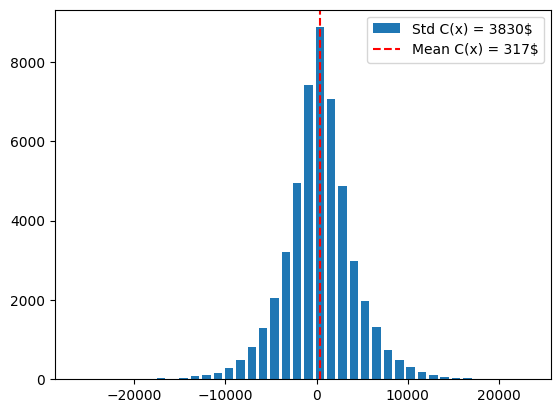

In [40]:
plot_histogram(simexp_lst[0][0])

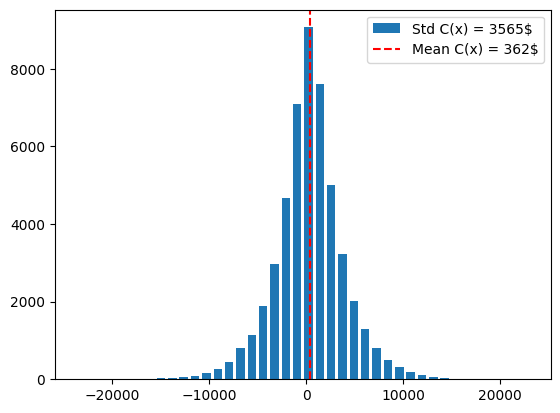

In [41]:
plot_histogram(simexp_lst[0][1])

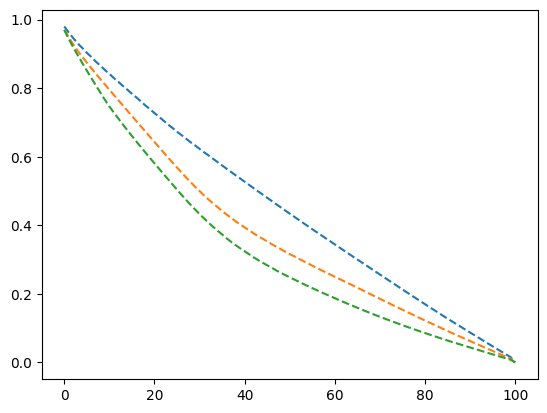

In [42]:
x_arr1 = np.array(simexp_lst[0][2])
x_arr2 = np.array(simexp_lst[1][2])
x_arr3 = np.array(simexp_lst[2][2])
plot_shares(np.append(np.mean(x_arr1,axis=0),0),"dashed")
plot_shares(np.append(np.mean(x_arr2,axis=0),0),"dashed")
plot_shares(np.append(np.mean(x_arr3,axis=0),0),"dashed")

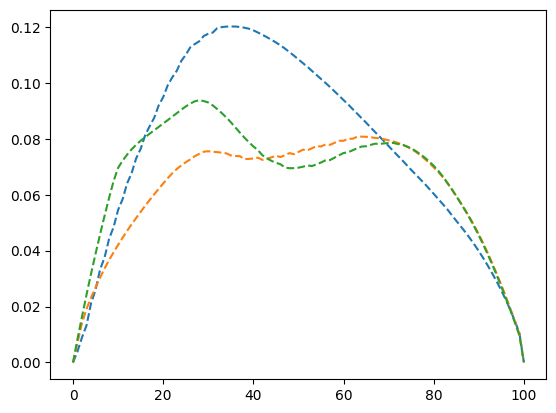

In [43]:
plot_shares(np.append(np.std(x_arr1,axis=0),0),"dashed")
plot_shares(np.append(np.std(x_arr2,axis=0),0),"dashed")
plot_shares(np.append(np.std(x_arr3,axis=0),0),"dashed")

# Mean-Variance

## Restricted